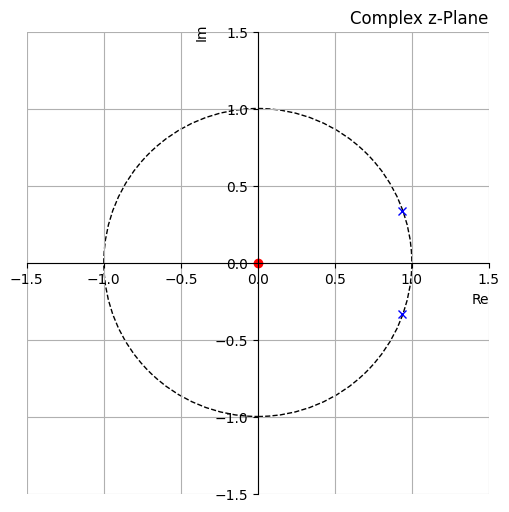

In [55]:
import numpy as np
import matplotlib.pyplot as plt

Q=0.995
Omega= 2*np.pi*440/8000
p0 = Q*np.exp(1j*Omega)
p1 = Q*np.exp(-1j*Omega)
# Plot Poles and Zeros
from  matplotlib import patches
plt.figure(figsize=(8,6))
ax = plt.subplot(111)
r = 1.5; plt.axis('scaled'); plt.axis([-r, r, -r, r])
#ticks = [-1, 1]; plt.xticks(ticks); plt.yticks(ticks)
# Unit Circle
uc = patches.Circle((0,0), radius=1, fill=False, color='black', ls='dashed')
ax.add_patch(uc)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Re', horizontalalignment='right', x=1.0)
plt.ylabel('Im',  y=1.0)
plt.title('Complex z-Plane', loc='right')
plt.grid()
plt.plot(0,0,'ro')
plt.plot(np.real(p0),np.imag(p0),'bx')
plt.plot(np.real(p1),np.imag(p1),'bx')

In [56]:
from scipy import signal as sig
Fs=8000
seq_len=Fs*2
omega=2*np.pi*440.0 /Fs
k1=2*Q*np.cos(omega)
k2=-pow(Q,2)
ximp=np.zeros(seq_len) #make impulse with a desired sequence length
ximp[0]=0.1 #impulse at the beginning
filtered=sig.lfilter([1], np.array([1, -k1,-k2]), ximp)

In [57]:
import IPython.display as ipd
ipd.Audio(filtered, rate=Fs)

In [34]:
import torch
import torch.nn as nn
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device)  

infeatures= 1 # samples per input time step
hiddensize= 3 #number of hidden states, the memory elements
outputs=1 #1 samples per output time step
numlayers=1 #number of layers of the network
batch=1

device= cpu


In [35]:
class RNNnet(nn.Module):
    def __init__(self, infeatures, hiddensize, outputs):
        super(RNNnet, self).__init__()
        
        # Define the model.
        self.rnn = nn.RNN(input_size=infeatures, hidden_size=hiddensize, num_layers=numlayers, bias=False)
        #forward layer for output
        self.fo = nn.Linear(hiddensize, outputs, bias=False)
        
    def forward(self, x):
        h_0 = torch.zeros(numlayers, batch, hiddensize).to(device)
        out, hn = self.rnn(x, h_0)
        #Output is simply the hidden state of the last layer (if more than 1 layer)
        out = self.fo(out) #e.g. used to just keep first output
        return out

In [36]:
def signal2pytorch(x):
    #Function to convert a signal vector x, like a mono audio signal, into a 3-d Tensor that Pytorch expects,
    #https://pytorch.org/docs/stable/nn.html
    #Argument x: a 1-d signal as numpy array
    #output: 3-d Pytorch Tensor.
    #for RNN Input: (siglen,batch,features)
    X = np.expand_dims(x, axis=-1) #add batch dimension (here only 1 )
    X = np.expand_dims(X, axis=-1) #add features dimension (here only 1 )
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    return X

In [37]:
import numpy as np
Fs=8000
omega=2*np.pi*440.0 /Fs; #normalized frequency
Q=0.995 #determines speed of decay, the closer to 1 the longer
k1=2*Q*np.cos(omega)
k2=-pow(Q,2)

In [38]:
from scipy import signal as sig
import IPython.display as ipd
seq_len=Fs*2
ximp=np.zeros(seq_len) #make impulse with a desired sequence length
ximp[0]=0.1 #impulse at the beginning
filtered=sig.lfilter([1], np.array([1, -k1,-k2]), ximp)
print("The impulse response sound from the I.I.R. filter")
display(ipd.Audio(filtered, rate= Fs))

The impulse response sound from the I.I.R. filter


In [39]:
"""
RNN as IIR Filter: hidden states h as delay chain 
Weights for updating h for shifting the delay line:
s=array([[0,0,0],[1,0,0],[0,1,0]]) 
In [4]: s      
array([[0, 0, 0],
       [1, 0, 0],
       [0, 1, 0]])

Application of IIR coefficients a(1)=2, a(2)=3:
a=array([[1,2,3],[0,1,0],[0,0,1]])                                      

In [2]: a 
Out[2]: 
array([[1, 2, 3],
       [0, 1, 0],
       [0, 0, 1]])
First apply shift operator s and then coefficents, h multiplied from right:
dot(a,s)
array([[2, 3, 0],
       [1, 0, 0],
       [0, 1, 0]])
this is w_hh.
""";

In [40]:
rnn = RNNnet(infeatures, hiddensize, outputs)
#Shifted diagonal matrix and IIR Filter coefficients:
rnn.state_dict()['rnn.weight_hh_l0'].data.copy_(torch.diag(torch.ones(hiddensize-1),diagonal=-1))
rnn.state_dict()['rnn.weight_hh_l0'][0,:].data.copy_(torch.tensor([ k1, k2,0.0]))
#Vector with a "1" for input x:
rnn.state_dict()['rnn.weight_ih_l0'].data.copy_(torch.zeros((hiddensize,1)))
rnn.state_dict()['rnn.weight_ih_l0'][0,0].data.copy_(torch.tensor(1.0))
#Weight for linear output layer to select h[0]:
rnn.state_dict()['fo.weight'][0,:].data.copy_(torch.tensor([1.0,0.0 ,0.0]))
ww = rnn.state_dict() #read obtained weights
print("weights =", ww)

weights = OrderedDict([('rnn.weight_ih_l0', tensor([[1.],
        [0.],
        [0.]])), ('rnn.weight_hh_l0', tensor([[ 1.8724, -0.9900,  0.0000],
        [ 1.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000]])), ('fo.weight', tensor([[1., 0., 0.]]))])


In [41]:
#the input, converted from the Numpy array:
inputsig=signal2pytorch(ximp)
#Run Recurrent Neural Network:
outsig= rnn(inputsig)

In [42]:
outsig=outsig.detach()
outsig=np.array(outsig) #turn into numpy array
outsig=outsig[:,0,0]
print("The sound from the recurrent neural network")
display(ipd.Audio(outsig, rate=Fs))

The sound from the recurrent neural network


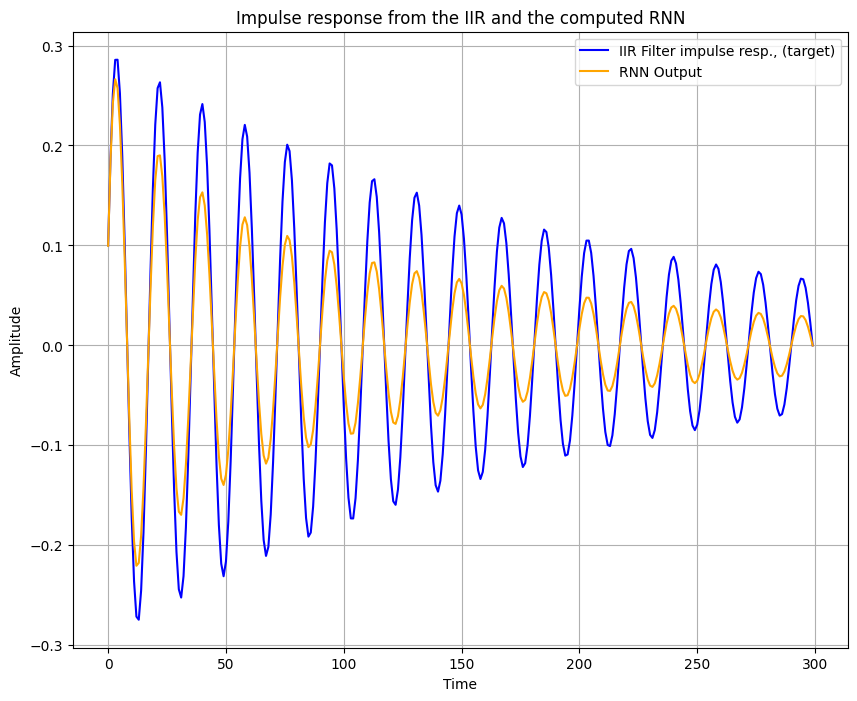

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(filtered[:300], 'blue')
plt.plot(outsig[:300],'orange')
plt.legend(('IIR Filter impulse resp., (target)','RNN Output'))
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title("Impulse response from the IIR and the computed RNN")
plt.grid()

In [44]:
#input is the pulse, with the 0.1 in the beginning, target is the output of the IIR filter:
target= signal2pytorch(filtered)
print("target.type()=", target.type())
print("target=", target)

target.type()= torch.FloatTensor
target= tensor([[[ 1.0000e-01]],

        [[ 1.8724e-01]],

        [[ 2.5157e-01]],

        ...,

        [[-2.8209e-36]],

        [[-1.4916e-36]],

        [[ 0.0000e+00]]])


In [45]:
#random starting point as initialization:
rnn.state_dict()['rnn.weight_hh_l0'].data.copy_(torch.randn(hiddensize,hiddensize))
#rnn.state_dict()['rnn.weight_hh_l0'].data.copy_(torch.zeros(hiddensize,hiddensize))
rnn.state_dict()['rnn.weight_ih_l0'].data.copy_(torch.randn((hiddensize,1)))
#rnn.state_dict()['rnn.weight_ih_l0'].data.copy_(torch.zeros((hiddensize,1)))
#rnn.state_dict()['fo.weight'][0,:].data.copy_(torch.tensor([ 1.0, 0.0 ,0.0]))
#rnn.state_dict()['fo.weight'][0,:].data.copy_(torch.zeros(hiddensize))
rnn.state_dict()['fo.weight'][0,:].data.copy_(torch.randn(hiddensize))

tensor([-0.8782, -1.3228, -0.0902])

In [46]:
rnn = RNNnet(infeatures, hiddensize, outputs).to(device)
ww = rnn.state_dict() #read current weights
print("weights =", ww)
print('Total number of parameters: %i' % (sum(p.numel() for p
in rnn.parameters() if p.requires_grad)))
loss_fn = nn.MSELoss(reduction='sum')
#learning_rate = 1e-3
optimizer = torch.optim.Adam(rnn.parameters())
for epoch in range(500):
    Ypred=rnn(inputsig)
    loss=loss_fn(Ypred, target)
    if epoch%10==0:
        print(epoch, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

weights = OrderedDict([('rnn.weight_ih_l0', tensor([[ 0.4776],
        [-0.4512],
        [-0.3389]])), ('rnn.weight_hh_l0', tensor([[ 0.2738, -0.1824,  0.1227],
        [-0.3203, -0.1178, -0.1392],
        [ 0.0519,  0.4503, -0.4261]])), ('fo.weight', tensor([[-0.2246, -0.3554,  0.2195]]))])
Total number of parameters: 15
0 4.391043663024902
10 4.390157222747803
20 4.389317989349365
30 4.388519287109375
40 4.387748718261719
50 4.386981964111328
60 4.386186122894287
70 4.385321140289307
80 4.384339332580566
90 4.383176803588867
100 4.381751537322998
110 4.379958629608154
120 4.377667427062988
130 4.374718189239502
140 4.370918273925781
150 4.36605167388916
160 4.359899997711182
170 4.352312088012695
180 4.343331336975098


KeyboardInterrupt: 

In [ ]:
#the input, converted from the Numpy array:
inputsig=signal2pytorch(ximp)
#Run Recurrent Neural Network:
outsig= rnn(inputsig)

In [ ]:
outsig=outsig.detach()
outsig=np.array(outsig) #turn into numpy array
outsig=outsig[:,0,0]
print("The sound from the recurrent neural network")
display(ipd.Audio(outsig, rate=Fs))

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(filtered[:300], 'blue')
plt.plot(outsig[:300],'orange')
plt.legend(('IIR Filter impulse resp., (target)','RNN Output'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title("Impulse response from the IIR and the computed RNN")
plt.grid()